# Final Project: Data-Driven Classification of Short-Term Stock Market Risk

## ME 371: Data-Driven Problem Solving
## Fall 2025

**Name**: Hyungkyu Lee  
**Date**: December 19, 2025  
**Dataset**: Index Brown, M. (2013). Dow Jones Index [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5788V.

# Table of Contents

1. Introduction and Problem Statement
2. Data Loading and Overview
3. Exploratory Data Analysis
4. Data Preprocessing
5. Model Development
   - Model 1: [Random Forest]
   - Model 2: [Logistic Regression]
   - Model 3: [K-Nearest Neighbour]
6. Model Optimization
7. Model Evaluation and Comparison
8. Results and Discussion
9. Conclusions
10. References

# Introduction and Problem Statement <a name="introduction"></a>

## Goal
The goal of this project is to predict the risk level of a Dow Jones stock for the upcoming week, based on its performance data from the current week.  
## Classification Problem: 
Predict whether a stock will fall into Low Risk or High Risk based on the expected price volatility for next week.  
## Importance
Short-term investors must predict returns and manage risk. This model will help people make more informed stock-buying decisions.

## Target Classes
Classes are formed by categorizing next week volatility (percentage range between high and low relative to open price).

* Low Risk — Volatility < 4%

* High Risk — 4% ≤ Volatility



**Equation:**  

Let:

$$ V_{next} = \frac{High - Low}{Open} \times 100 $$

Then the risk categories are defined as:

$$
\text{Risk}(V_{\text{next}}) =
\begin{cases}
\text{Low Risk} & 0 \le V_{\text{next}} < 4 \\
\text{High Risk} & V_{\text{next}} \ge 4
\end{cases}
$$

# Data Loading and Overview <a name="sec2"></a>

# Library Imports

In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: model selection & validation
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
)

# Scikit-learn: preprocessing
from sklearn.preprocessing import StandardScaler

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn: metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# Importing & Preprocessing Data

In [201]:
df = pd.read_csv("dow+jones+index/dow_jones_index.data")
print('='*25, 'Data Head', '='*25)
display(df.head())
print('\n\n','='*25, 'Data Info', '='*25)
df.info()

print('\n\n','='*25, 'Data Describe', '='*25)
df.describe()

========================= Data Head =========================


,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029




 ========================= Data Info =========================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-n

,quarter,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
count,750.000000,7.500000e+02,750.000000,720.000000,7.200000e+02,750.000000,750.000000,750.000000
mean,1.520000,1.175478e+08,0.050262,5.593627,1.173876e+08,0.238468,52.525333,0.691826
std,0.499933,1.584381e+08,2.517809,40.543478,1.592322e+08,2.679538,46.335098,0.305482
min,1.000000,9.718851e+06,-15.422900,-61.433175,9.718851e+06,-15.422900,0.000000,0.065574
25%,1.000000,3.086624e+07,-1.288053,-19.804284,3.067832e+07,-1.222068,24.000000,0.534549
50%,2.000000,5.306088e+07,0.000000,0.512586,5.294556e+07,0.101193,47.000000,0.681067
75%,2.000000,1.327218e+08,1.650888,21.800622,1.333230e+08,1.845562,69.000000,0.854291
max,2.000000,1.453439e+09,9.882230,327.408924,1.453439e+09,9.882230,336.000000,1.564210


# 3. Data Preprocessing

In [202]:
df['date'] = pd.to_datetime(df['date'])

print(df.isna().sum())

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64


The first observation for each stock contains missing values for the **percent_change_volume_over_last_wk** and **previous_weeks_volume** features because these variables require data from a prior week. Since the dataset begins at the first recorded date for each stock, these values cannot be computed and were therefore dropped.

In [203]:
df = df.sort_values(["stock", "date"])
df = df[df.groupby("stock").cumcount() != 0]
print(df.isna().sum())

quarter                               0
stock                                 0
date                                  0
open                                  0
high                                  0
low                                   0
close                                 0
volume                                0
percent_change_price                  0
percent_change_volume_over_last_wk    0
previous_weeks_volume                 0
next_weeks_open                       0
next_weeks_close                      0
percent_change_next_weeks_price       0
days_to_next_dividend                 0
percent_return_next_dividend          0
dtype: int64


## Converting price columns to float

In [204]:
price_cols = [
    "open",
    "high",
    "low",
    "close",
    "next_weeks_open",
    "next_weeks_close"
]


for col in price_cols:
    df[col] = df[col].replace(r"[^0-9.-]", "", regex=True).astype(float)

print(df.dtypes)
print(df.isna().sum().sum())

quarter                                        int64
stock                                         object
date                                  datetime64[ns]
open                                         float64
high                                         float64
low                                          float64
close                                        float64
volume                                         int64
percent_change_price                         float64
percent_change_volume_over_last_wk           float64
previous_weeks_volume                        float64
next_weeks_open                              float64
next_weeks_close                             float64
percent_change_next_weeks_price              float64
days_to_next_dividend                          int64
percent_return_next_dividend                 float64
dtype: object
0


## Divide risks into category: next_week_risk

0 low risk 1 high

In [205]:
# This week's volatility (% range)

df["weekly_volatility"] = np.where(
    df["open"] == 0,
    0,
    (df["high"] - df["low"]) / df["open"] * 100
)

# Next week's volatility
df["next_week_volatility"] = df.groupby("stock")["weekly_volatility"].shift(-1)

# Drop rows where next week doesn't exist (last week per stock)
df = df.dropna(subset=["next_week_volatility"]).reset_index(drop=True)
print("\nAfter next_week_volatility, shape:", df.shape)

# Binary risk: High vs Low
bins = [0, 4, np.inf]   # threshold at 4%
labels = [0, 1]         # 0 = Not High, 1 = High

df["next_week_risk"] = pd.cut(
    df["next_week_volatility"],
    bins=[0, 4, np.inf],
    labels=[0, 1],
    include_lowest=True
).astype(int)


print("\nNext_week_risk distribution:")
print(df["next_week_risk"].value_counts())




After next_week_volatility, shape: (690, 18)

Next_week_risk distribution:
next_week_risk
0    417
1    273
Name: count, dtype: int64


# 4. Exploratory Data Analysis

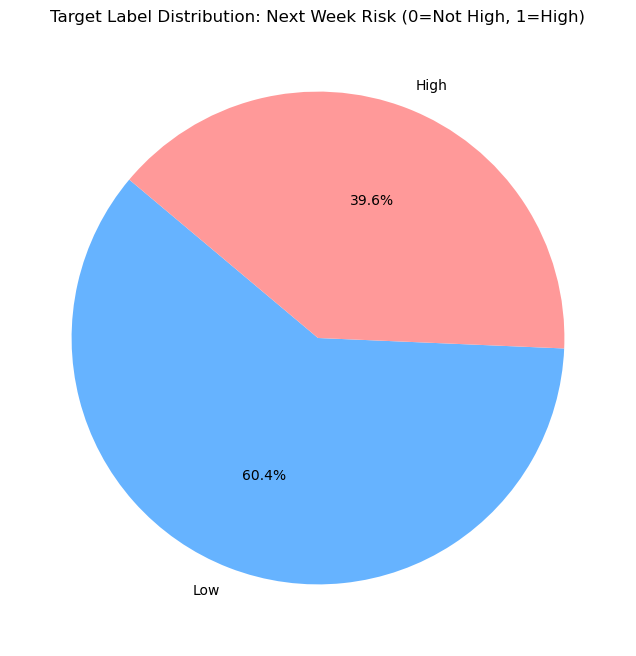

In [206]:
df['next_week_risk_label'] = df['next_week_risk'].map({0: 'Low', 1: 'High'})

risk_distribution = df['next_week_risk_label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    risk_distribution,
    labels=risk_distribution.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#66b3ff', '#ff9999']
)
plt.title('Target Label Distribution: Next Week Risk (0=Not High, 1=High)')
plt.ylabel('')
plt.show()


The dataset is very imbalanced.  
SMOTE (Synthetic Minority Over-sampling Technique) will be used later to address this.

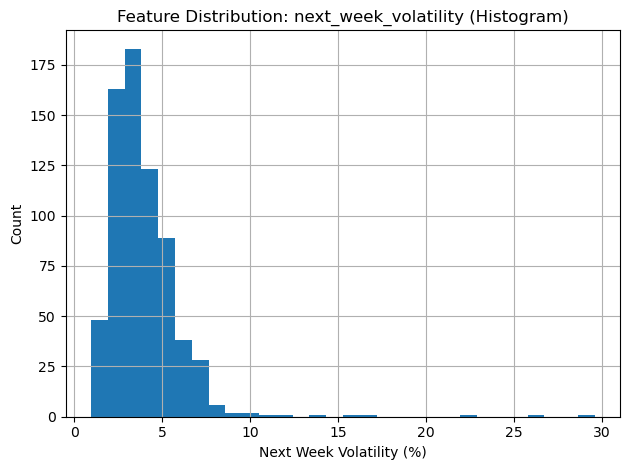

In [207]:
plt.figure()
df["next_week_volatility"].hist(bins=30)
plt.title("Feature Distribution: next_week_volatility (Histogram)")
plt.xlabel("Next Week Volatility (%)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

/var/folders/66/d694mm891ll797vx8kxt0ktr0000gn/T/ipykernel_37629/882986957.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


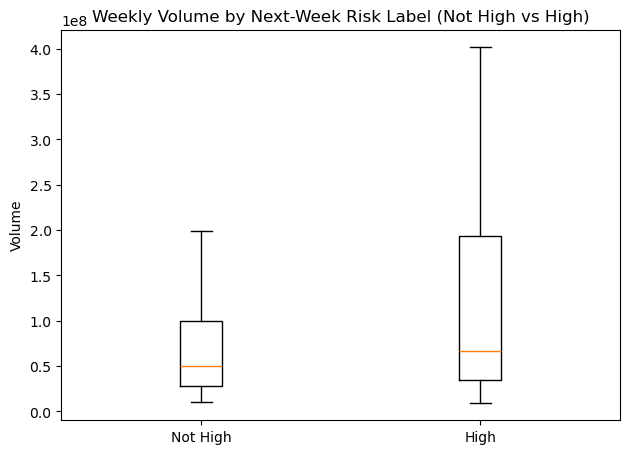

In [208]:
plt.figure()

order = [0, 1]
label_map = {0: "Not High", 1: "High"}

data_for_box = [
    df.loc[df["next_week_risk"] == r, "volume"]
    for r in order
]

plt.boxplot(
    data_for_box,
    labels=[label_map[r] for r in order],
    showfliers=False
)

plt.title("Weekly Volume by Next-Week Risk Label (Not High vs High)")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()


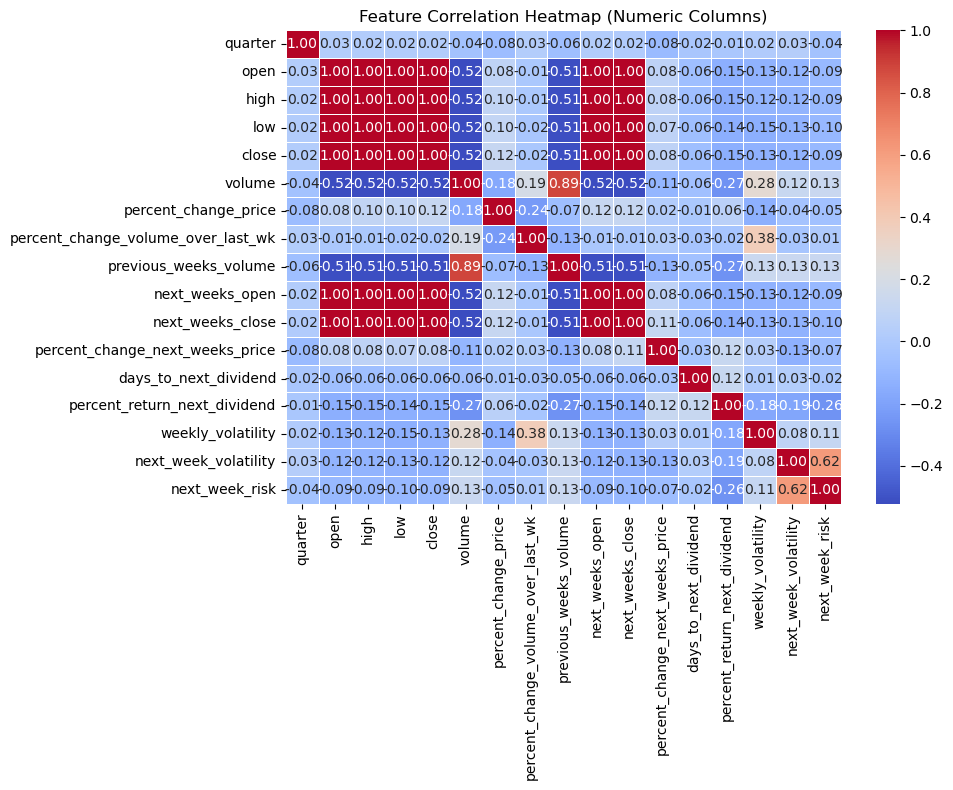

In [209]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
corr = df[numeric_cols].corr()

corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Numeric Columns)")
plt.tight_layout()
plt.show()

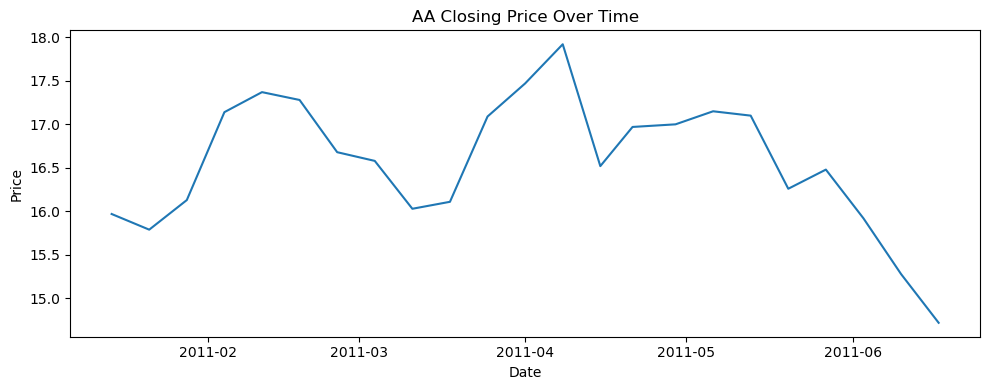

In [210]:
stock = "AA"  # example ticker

df_stock = df[df["stock"] == stock].sort_values("date")

plt.figure(figsize=(10,4))
plt.plot(df_stock["date"], df_stock["close"], label="Close Price")

plt.title(f"{stock} Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()



# Data Preprocessing

## Prepare Features X and Target y

In [211]:
y = df["next_week_risk"]

# drop columns that shouldn't be features (don't want future info)
drop_cols = [
    "date",                        # not using date as numeric feature
    "next_weeks_open",             # future info
    "next_weeks_close",            # future info
    "percent_change_next_weeks_price",  # future info
    "next_week_volatility",        # numeric version of target
    "next_week_risk",              # target itself
    "next_week_risk_label",
]

X = df.drop(columns=drop_cols, errors="coerce")

# Include stock ticker
X = pd.get_dummies(X, columns=["stock"], drop_first=True)

print("\nFeature matrix shape:", X.shape)
print("Feature columns:", X.columns[:])
print(df.isnull().sum())


Feature matrix shape: (690, 41)
Feature columns: Index(['quarter', 'open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'percent_change_volume_over_last_wk',
       'previous_weeks_volume', 'days_to_next_dividend',
       'percent_return_next_dividend', 'weekly_volatility', 'stock_AXP',
       'stock_BA', 'stock_BAC', 'stock_CAT', 'stock_CSCO', 'stock_CVX',
       'stock_DD', 'stock_DIS', 'stock_GE', 'stock_HD', 'stock_HPQ',
       'stock_IBM', 'stock_INTC', 'stock_JNJ', 'stock_JPM', 'stock_KO',
       'stock_KRFT', 'stock_MCD', 'stock_MMM', 'stock_MRK', 'stock_MSFT',
       'stock_PFE', 'stock_PG', 'stock_T', 'stock_TRV', 'stock_UTX',
       'stock_VZ', 'stock_WMT', 'stock_XOM'],
      dtype='object')
quarter                               0
stock                                 0
date                                  0
open                                  0
high                                  0
low                                   0
close                      

## Test Train Split

test size = 0.3

In [212]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("\nTrain size:", X_train.shape[0], "Test size:", X_test.shape[0])
print(X.isna().sum().sum(), " Missing X Values Total")
print(X_train.isna().sum().sum(), " Missing X_train Values Total")
print(y_train.isna().sum().sum(), " Missing y_trainValues Total")



Train size: 483 Test size: 207
0  Missing X Values Total
0  Missing X_train Values Total
0  Missing y_trainValues Total


In [213]:
display(X)

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,days_to_next_dividend,...,stock_MRK,stock_MSFT,stock_PFE,stock_PG,stock_T,stock_TRV,stock_UTX,stock_VZ,stock_WMT,stock_XOM
0,1,16.71,16.71,15.64,15.97,242963398,-4.428490,1.380223,239655616.0,19,...,False,False,False,False,False,False,False,False,False,False
1,1,16.19,16.38,15.60,15.79,138428495,-2.470660,-43.024959,242963398.0,12,...,False,False,False,False,False,False,False,False,False,False
2,1,15.87,16.63,15.82,16.13,151379173,1.638310,9.355500,138428495.0,5,...,False,False,False,False,False,False,False,False,False,False
3,1,16.18,17.39,16.18,17.14,154387761,5.933250,1.987452,151379173.0,97,...,False,False,False,False,False,False,False,False,False,False
4,1,17.33,17.48,16.97,17.37,114691279,0.230814,-25.712195,154387761.0,90,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,2,80.22,82.58,79.60,81.57,86758820,1.682870,-12.961001,99678100.0,82,...,False,False,False,False,False,False,False,False,False,True
686,2,80.22,82.63,80.07,82.63,68230855,3.004240,-21.355713,86758820.0,75,...,False,False,False,False,False,False,False,False,False,True
687,2,83.28,83.75,80.18,81.18,78616295,-2.521610,15.221032,68230855.0,68,...,False,False,False,False,False,False,False,False,False,True
688,2,80.93,81.87,79.72,79.78,92380844,-1.420980,17.508519,78616295.0,61,...,False,False,False,False,False,False,False,False,False,True


# 5. Model Development

## Model 1. [Base Random Forest]


=== Random Forest Classification Summary ===
Classes in y_test: [0 1]
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       125
           1       0.59      0.44      0.50        82

    accuracy                           0.66       207
   macro avg       0.64      0.62      0.62       207
weighted avg       0.65      0.66      0.65       207



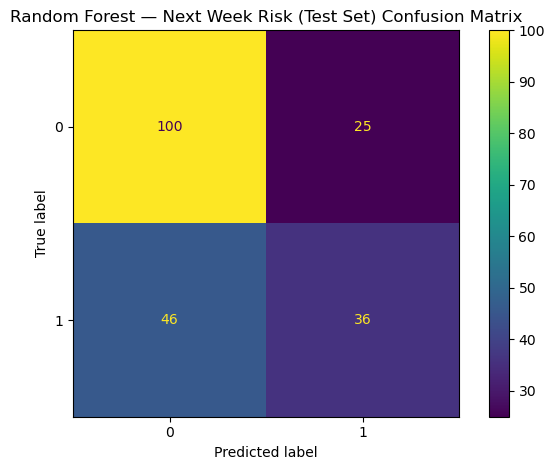

In [214]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("\n=== Random Forest Classification Summary ===")
print("Classes in y_test:", np.unique(y_test))
print(classification_report(y_test, y_pred_rf, zero_division=0))

labels = np.unique(np.concatenate([y_test, y_pred_rf]))
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
disp_rf.plot()
plt.title("Random Forest — Next Week Risk (Test Set) Confusion Matrix")
plt.tight_layout()
plt.show()

The Random Forest model predicts Low and High risk reasonably well, but Medium risk is the most ambiguous class and is frequently confused with both adjacent categories.

## Model 2: [Base Logistic Regression]

In [215]:
# Create Logistic Regression classifier
lr = LogisticRegression(max_iter=500)

# Train the model
lr.fit(X_train, y_train)

# Predictions (labels)
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr  = lr.predict(X_test)

# Predictions (probabilities)  ✅ needed for log loss
y_train_proba_lr = lr.predict_proba(X_train)
y_test_proba_lr  = lr.predict_proba(X_test)

print("Logistic Regression model trained successfully!")
print("Classes:", lr.classes_)

Logistic Regression model trained successfully!
Classes: [0 1]


In [216]:
# Metrics
acc_train_lr = accuracy_score(y_train, y_train_pred_lr)
acc_test_lr  = accuracy_score(y_test, y_test_pred_lr)

# For multiclass use weighted (safe default)
f1_train_lr = f1_score(y_train, y_train_pred_lr, average="weighted")
f1_test_lr  = f1_score(y_test, y_test_pred_lr, average="weighted")

# Log loss uses probabilities (not class labels)
log_train_lr = log_loss(y_train, y_train_proba_lr, labels=lr.classes_)
log_test_lr  = log_loss(y_test, y_test_proba_lr, labels=lr.classes_)

print(f"Train: Acc={acc_train_lr:.4f}, F1={f1_train_lr:.4f}, LogLoss={log_train_lr:.4f}")
print(f"Test : Acc={acc_test_lr:.4f}, F1={f1_test_lr:.4f}, LogLoss={log_test_lr:.4f}")


Train: Acc=0.6108, F1=0.5175, LogLoss=0.6676
Test : Acc=0.6087, F1=0.4960, LogLoss=0.6606


In [217]:
# Show first 10 probability predictions (works for binary or multiclass)
print("\nSample probability predictions (first 10):")
for i in range(min(10, len(y_test))):
    actual = y_test.iloc[i]
    predicted = y_test_pred_lr[i]
    proba = y_test_proba_lr[i]
    proba_str = ", ".join([f"P({cls})={p:.3f}" for cls, p in zip(lr.classes_, proba)])
    print(f"Sample {i}: Actual={actual}, Predicted={predicted}, {proba_str}")


Sample probability predictions (first 10):
Sample 0: Actual=0, Predicted=0, P(0)=0.646, P(1)=0.354
Sample 1: Actual=0, Predicted=0, P(0)=0.652, P(1)=0.348
Sample 2: Actual=1, Predicted=0, P(0)=0.533, P(1)=0.467
Sample 3: Actual=1, Predicted=0, P(0)=0.529, P(1)=0.471
Sample 4: Actual=0, Predicted=0, P(0)=0.565, P(1)=0.435
Sample 5: Actual=1, Predicted=0, P(0)=0.535, P(1)=0.465
Sample 6: Actual=0, Predicted=0, P(0)=0.604, P(1)=0.396
Sample 7: Actual=0, Predicted=0, P(0)=0.658, P(1)=0.342
Sample 8: Actual=1, Predicted=0, P(0)=0.569, P(1)=0.431
Sample 9: Actual=0, Predicted=0, P(0)=0.624, P(1)=0.376


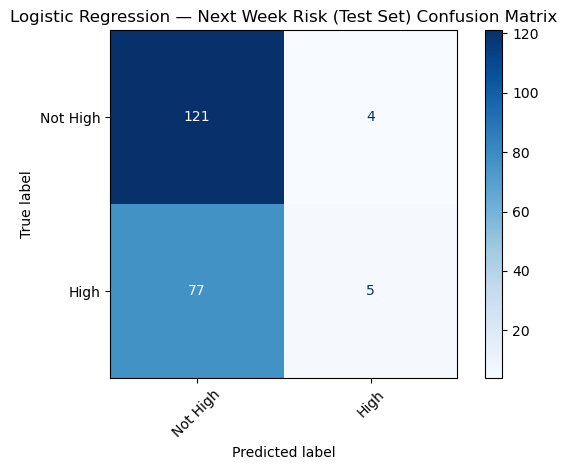

Confusion Matrix:
[[121   4]
 [ 77   5]]


In [218]:
# Create confusion matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr, labels=lr.classes_)

# Display confusion matrix
disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["Not High", "High"]

)

disp_lr.plot(cmap="Blues", xticks_rotation=45)
plt.title("Logistic Regression — Next Week Risk (Test Set) Confusion Matrix")
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm_lr)

The confusion matrix shows that Logistic Regression frequently predicts the Low-risk class.

## Model 3: [Base K-Nearest Neighbors]


BASELINE MODEL - K-Nearest Neighbors

Accuracy:  0.6135
Precision: 0.5143
Recall:    0.4390
F1-Score:  0.4737


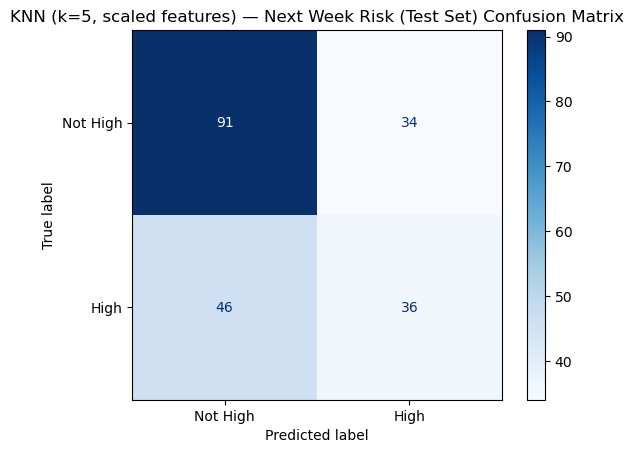

In [219]:
from sklearn.neighbors import KNeighborsClassifier

# TODO: scale features using StandardScaler (essential for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# training the baseline KNN model
print("\n" + "="*80)
print("BASELINE MODEL - K-Nearest Neighbors")
print("="*80)

# TODO: defining and training your knn model with k = 5
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_scaled, y_train)

# making predictions
y_pred_baseline = knn_baseline.predict(X_test_scaled)

# evaluation
print(f"\nAccuracy:  {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_baseline):.4f}")

# confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(cm_baseline, display_labels=["Not High", "High"])
disp.plot(cmap='Blues')
plt.title('KNN (k=5, scaled features) — Next Week Risk (Test Set) Confusion Matrix')
plt.show()

# 6. Model Optimization

## Using SMOTE (SYNTHETIC MINORITY OVER-SAMPLING) for K-NN


SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)

Original training set size: 483
After SMOTE: 584

Class distribution after SMOTE:
next_week_risk
1    292
0    292
Name: count, dtype: int64

Accuracy:  0.5797
Precision: 0.4742
Recall:    0.5610
F1-Score:  0.5140


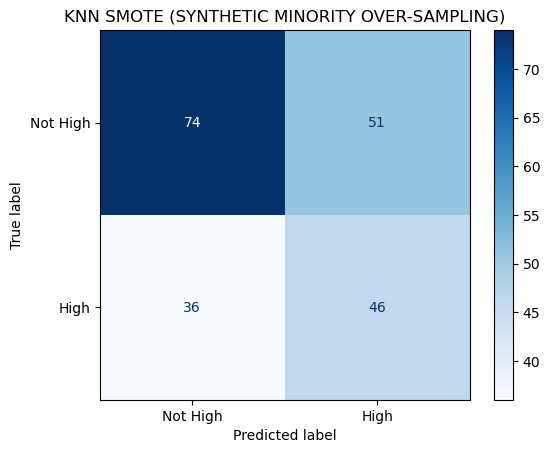

In [220]:
print("\n" + "="*80)
print("SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)")
print("="*80)

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal training set size: {len(X_train_scaled)}")
print(f"After SMOTE: {len(X_train_smote)}")
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Train KNN on SMOTE data
knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_train_smote, y_train_smote)

# Predict using the SAME model
y_pred_smote = knn_smote.predict(X_test_scaled)

# Evaluate (binary)
print(f"\nAccuracy:  {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_smote, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_smote, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_smote, zero_division=0):.4f}")


# confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(cm_baseline, display_labels=["Not High", "High"])
disp.plot(cmap='Blues')
plt.title('KNN SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)')
plt.show()


After applying SMOTE to balance the training data, the KNN classifier achieved an accuracy of 58%


KNN COMPARISON WITH RESAMPLING
  Method  Accuracy  Precision   Recall  F1-Score
Baseline  0.613527   0.514286 0.439024  0.473684
   SMOTE  0.579710   0.474227 0.560976  0.513966


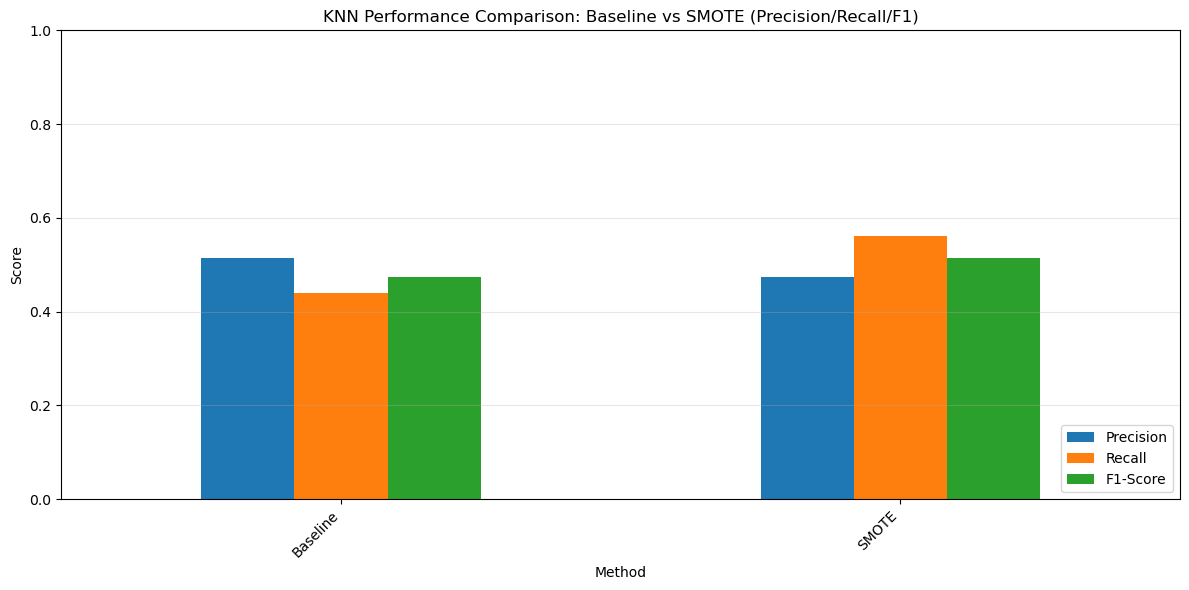

In [221]:
# DataFrame to  plot the comparison
comparison_df = pd.DataFrame({
    'Method': ['Baseline', 'SMOTE'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_smote)
    ],
    'Precision': [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_smote)
    ],
    'Recall': [
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_smote)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_smote)
    ]
})

print("\n" + "="*80)
print("KNN COMPARISON WITH RESAMPLING")
print("="*80)
print(comparison_df.to_string(index=False))

# comparing
comparison_df.set_index('Method')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6)
)
plt.title('KNN Performance Comparison: Baseline vs SMOTE (Precision/Recall/F1)')
plt.ylabel('Score')
plt.xlabel('Method')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Applying SMOTE to KNN improves recall and F1 score compared to the baseline model, but slightly reduces precision, indicating better detection of higher-risk cases at the cost of more false positives.

## K-FOLD CROSS-VALIDATION


K-FOLD CROSS-VALIDATION

5-Fold Cross-Validation Results:
F1 Scores for each fold: [0.76785714 0.7079646  0.67768595 0.66101695 0.56862745]
Mean F1 Score: 0.6766
Std F1 Score:  0.0651


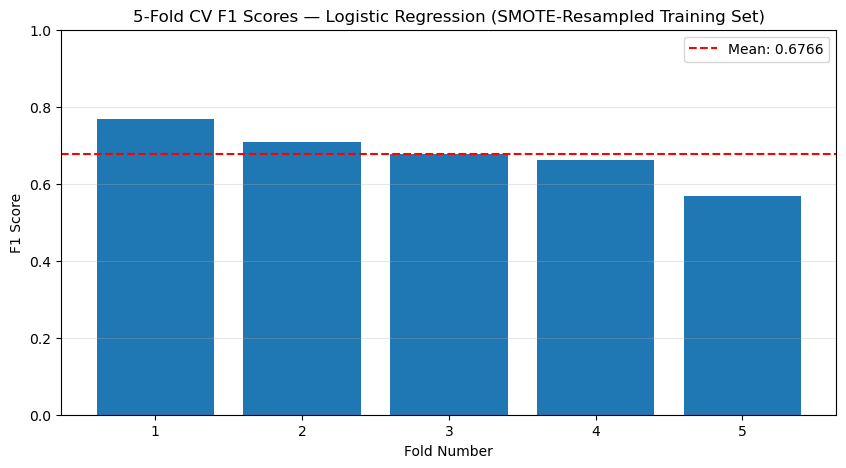

In [222]:
print("\n" + "="*80)
print("K-FOLD CROSS-VALIDATION")
print("="*80)

# logistic regression model object definition
lr = LogisticRegression(max_iter=1000, random_state=42)

# 5-Fold Cross-Validation implementation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kfold = cross_val_score(
    lr, X_train_smote, y_train_smote, cv=kfold, scoring='f1'
)

print("\n5-Fold Cross-Validation Results:")
print(f"F1 Scores for each fold: {scores_kfold}")
print(f"Mean F1 Score: {scores_kfold.mean():.4f}")
print(f"Std F1 Score:  {scores_kfold.std():.4f}")

# Visualize fold results
plt.figure(figsize=(10, 5))
plt.bar(range(1, 6), scores_kfold)
plt.axhline(y=scores_kfold.mean(), color='r', linestyle='--',
           label=f'Mean: {scores_kfold.mean():.4f}')
plt.xlabel('Fold Number')
plt.ylabel('F1 Score')
plt.title('5-Fold CV F1 Scores — Logistic Regression (SMOTE-Resampled Training Set)')
plt.legend()
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.show()

## Feature Selection

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

lr.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [224]:
feature_cols = X.columns.tolist()

feature_importance = pd.Series(
    np.abs(lr.coef_[0]),
    index=feature_cols
).sort_values(ascending=False)

print("Feature Importance (Logistic Regression):")
print(feature_importance)


Feature Importance (Logistic Regression):
stock_CAT                             1.012963
stock_WMT                             0.447497
percent_return_next_dividend          0.445761
stock_JNJ                             0.405448
stock_KRFT                            0.387122
stock_KO                              0.373602
stock_MCD                             0.343552
stock_DIS                             0.337384
stock_PG                              0.319265
low                                   0.311978
stock_CSCO                            0.291426
weekly_volatility                     0.287394
stock_PFE                             0.285804
stock_TRV                             0.248534
close                                 0.225259
stock_CVX                             0.210750
stock_MRK                             0.210160
stock_T                               0.209603
high                                  0.202013
previous_weeks_volume                 0.194172
open              

### Recursive Feature Elimination (RFE)

In [225]:
from sklearn.feature_selection import RFE

# Run RFE

rfe = RFE(
    estimator=LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    )
)

rfe.fit(X_train_scaled, y_train)


,estimator,LogisticRegre...max_iter=1000)
,n_features_to_select,None
,step,1
,verbose,0
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


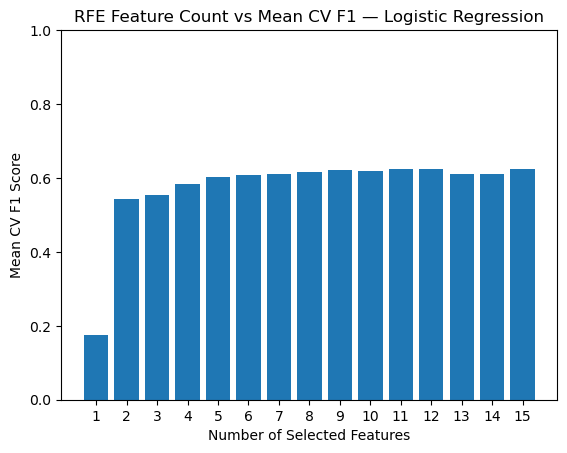

In [226]:
k_values = list(range(1, 16))
mean_f1_scores = []

for k in k_values:
    rfe = RFE(lr, n_features_to_select=k)
    rfe.fit(X_train_scaled, y_train)

    scores = cross_val_score(
        lr,
        X_train_scaled[:, rfe.support_],
        y_train,
        cv=5,
        scoring="f1"
    )

    mean_f1_scores.append(scores.mean())


plt.figure()
plt.bar([str(k) for k in k_values], mean_f1_scores)
plt.xlabel("Number of Selected Features")
plt.ylabel("Mean CV F1 Score")
plt.title("RFE Feature Count vs Mean CV F1 — Logistic Regression")
plt.ylim(0, 1)
plt.show()



The mean cross-validated F1 score increases up to five selected features and then remains relatively stable.

In [227]:
rfe_5 = RFE(
    estimator=lr,
    n_features_to_select=5
)

rfe_5.fit(X_train_scaled, y_train)

,estimator,LogisticRegre...max_iter=1000)
,n_features_to_select,5
,step,1
,verbose,0
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [228]:
selected_features = [
    feature for feature, keep
    in zip(feature_cols, rfe_5.support_)
    if keep
]

print("Selected features (RFE, k=5):")
print(selected_features)


Selected features (RFE, k=5):
['close', 'percent_return_next_dividend', 'stock_CAT', 'stock_CVX', 'stock_DD']


In [229]:
X_train_rfe = X_train_scaled[:, rfe_5.support_]
X_test_rfe  = X_test_scaled[:, rfe_5.support_]

cv_scores_rfe = cross_val_score(
    lr,
    X_train_rfe,
    y_train,
    cv=5,
    scoring="f1"
)

print(f"RFE (5 features) Mean CV F1: {cv_scores_rfe.mean():.4f}")
print(f"RFE (5 features) Std CV F1:  {cv_scores_rfe.std():.4f}")


RFE (5 features) Mean CV F1: 0.6032
RFE (5 features) Std CV F1:  0.0238


In [230]:
lr.fit(X_train_rfe, y_train)
y_test_pred_rfe = lr.predict(X_test_rfe)

print("\nFinal Test Performance (RFE, 5 features):")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred_rfe):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_rfe):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_rfe):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred_rfe):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rfe))



Final Test Performance (RFE, 5 features):
Accuracy:  0.6667
Precision: 0.5714
Recall:    0.6341
F1-Score:  0.6012

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       125
           1       0.57      0.63      0.60        82

    accuracy                           0.67       207
   macro avg       0.66      0.66      0.66       207
weighted avg       0.67      0.67      0.67       207



In [231]:
baseline_f1 = cross_val_score(
    lr,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="f1"
)

## Comparing Logistic Regression model with all features and 5 features using RFE

In [232]:
results = pd.DataFrame({
    "Model": ["All Features", "RFE (5 Features)"],
    "Mean CV F1": [
        baseline_f1.mean(),
        cv_scores_rfe.mean()
    ]
})

print(results)


              Model  Mean CV F1
0      All Features    0.571990
1  RFE (5 Features)    0.603174


In [233]:
comparison_df = pd.DataFrame({
    'Method': [
        'Base KNN',
        'SMOTE',
        'RFE (5 Features)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_smote),
        accuracy_score(y_test, y_test_pred_rfe)
    ],
    'Precision': [
        precision_score(y_test, y_pred_baseline, zero_division=0),
        precision_score(y_test, y_pred_smote, zero_division=0),
        precision_score(y_test, y_test_pred_rfe, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_baseline, zero_division=0),
        recall_score(y_test, y_pred_smote, zero_division=0),
        recall_score(y_test, y_test_pred_rfe, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_smote),
        f1_score(y_test, y_test_pred_rfe)
    ]
})

print(comparison_df)


             Method  Accuracy  Precision    Recall  F1-Score
0          Base KNN  0.613527   0.514286  0.439024  0.473684
1             SMOTE  0.579710   0.474227  0.560976  0.513966
2  RFE (5 Features)  0.666667   0.571429  0.634146  0.601156


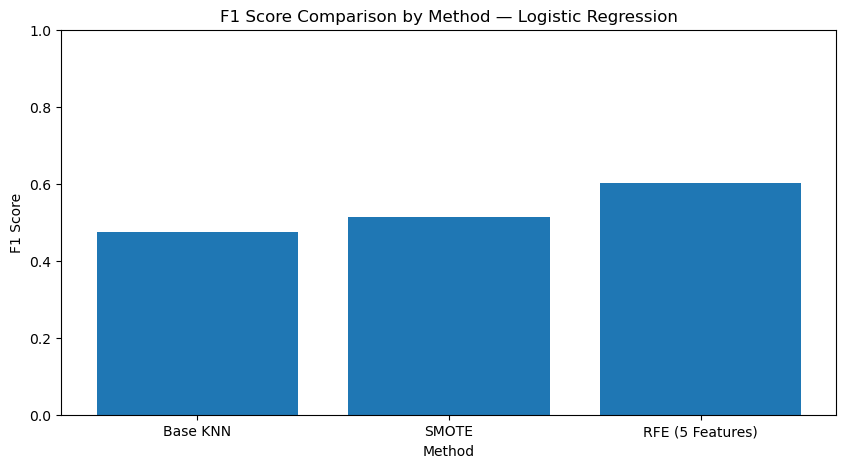

In [234]:
plt.figure(figsize=(10, 5))
plt.bar(comparison_df['Method'], comparison_df['F1-Score'])
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison by Method — Logistic Regression')
plt.ylim(0, 1)
plt.show()


## Performance of model using SMOTE + RFE

In [235]:
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rfe", RFE(
        estimator=LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs"
        ),
        n_features_to_select=5
    )),
    ("lr", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

scores = cross_val_score(
    pipe,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="f1"
)

In [236]:
pipe.fit(X_train_scaled, y_train)
y_pred_smote_rfe = pipe.predict(X_test_scaled)

print("Final Test Performance (SMOTE + RFE):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_smote_rfe):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_smote_rfe, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_smote_rfe, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_smote_rfe):.4f}")


Final Test Performance (SMOTE + RFE):
Accuracy:  0.6763
Precision: 0.5926
Recall:    0.5854
F1-Score:  0.5890


In [237]:
new_row = pd.DataFrame([{
    'Method': 'SMOTE + RFE (5 Features)',
    'Accuracy': accuracy_score(y_test, y_pred_smote_rfe),
    'Precision': precision_score(y_test, y_pred_smote_rfe, zero_division=0),
    'Recall': recall_score(y_test, y_pred_smote_rfe, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_smote_rfe)
}])

comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)

print(comparison_df)



                     Method  Accuracy  Precision    Recall  F1-Score
0                  Base KNN  0.613527   0.514286  0.439024  0.473684
1                     SMOTE  0.579710   0.474227  0.560976  0.513966
2          RFE (5 Features)  0.666667   0.571429  0.634146  0.601156
3  SMOTE + RFE (5 Features)  0.676329   0.592593  0.585366  0.588957


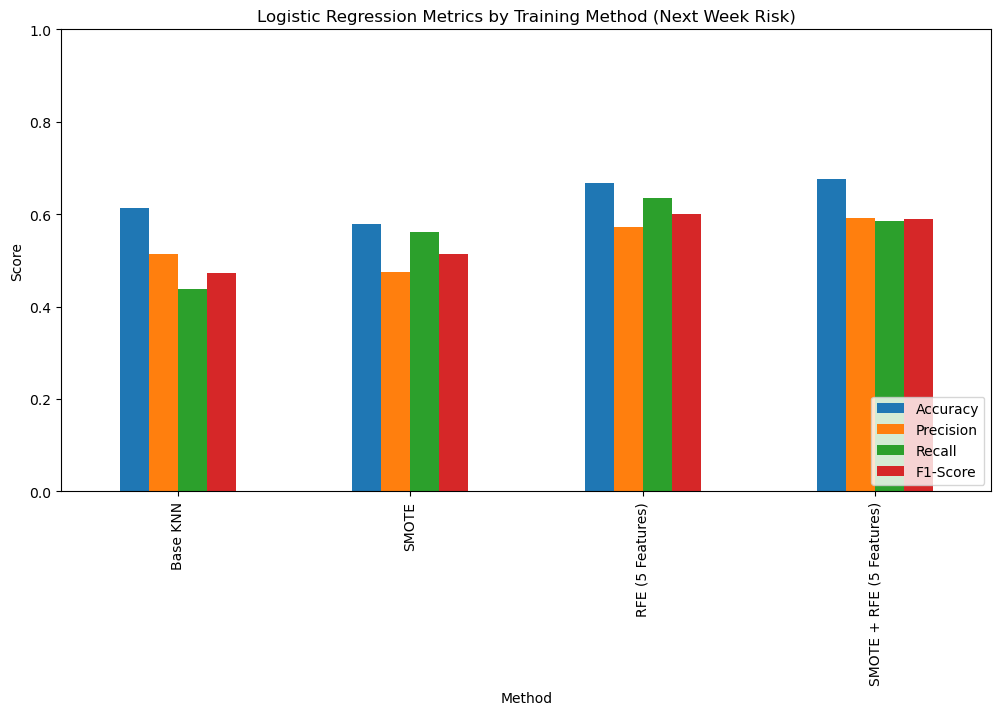

In [238]:
comparison_df.set_index('Method')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar',
    figsize=(12, 6)
)
plt.ylabel('Score')
plt.title('Logistic Regression Metrics by Training Method (Next Week Risk)')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()


## KNN Optimization

In [239]:
from sklearn.model_selection import GridSearchCV

print("\n" + "="*80)
print("GRID SEARCH - K-NEAREST NEIGHBORS")
print("="*80)

# Defining the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print(f"\nParameter grid:")
for param, values in param_grid_knn.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations to try: {6 * 2 * 3} = 36")
print(f"With 5-fold CV: {36 * 5} = 180 model fits\n")

# creating KNN classifier
knn = KNeighborsClassifier()

# Create GridSearchCV object with stratified k-fold scross validation k=5
grid_search_knn = GridSearchCV(
    estimator = knn,
    param_grid = param_grid_knn,
    cv = StratifiedKFold(5, shuffle = True, random_state=42),
    scoring = 'f1',
    n_jobs=-1,
    verbose=1,
    return_train_score = True
)

# Fit grid search (this may take a minute)
print("Starting grid search...")
grid_search_knn.fit(X_train_smote, y_train_smote)

# displaying the results
print(f"\n{'='*80}")
print("GRID SEARCH RESULTS")
print(f"{'='*80}")
print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_knn.best_score_:.4f}")

# evaluating on test set
best_knn = grid_search_knn.best_estimator_
y_pred_knn_tuned = best_knn.predict(X_test_scaled)

print(f"\nPerformance on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_knn_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_knn_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_knn_tuned):.4f}")


GRID SEARCH - K-NEAREST NEIGHBORS

Parameter grid:
  n_neighbors: [3, 5, 7, 9, 11, 13]
  weights: ['uniform', 'distance']
  metric: ['euclidean', 'manhattan', 'minkowski']

Total combinations to try: 36 = 36
With 5-fold CV: 180 = 180 model fits

Starting grid search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

GRID SEARCH RESULTS
Best parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}
Best cross-validation F1 score: 0.7134

Performance on Test Set:
Accuracy:  0.6329
Precision: 0.5306
Recall:    0.6341
F1-Score:  0.5778


In [240]:
print("\n" + "="*80)
print("GRID SEARCH - LOGISTIC REGRESSION")
print("="*80)

# TODO: efine parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both L1 and L2
}

# TODO: GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(
    estimator = lr,
    param_grid = param_grid_lr,
    cv = 5, #StratifiedKFold(5, shuffle = True, random_state=42),
    scoring = 'f1',
    n_jobs=-1,
    verbose=1,
   # return_train_score = True
)

# TODO: executing the grid search
print("Starting grid search...")
grid_search_lr.fit(X_train_smote, y_train_smote)

# TODO: results
print(f"\n{'='*80}")
print("GRID SEARCH RESULTS")
print(f"{'='*80}")
# YOUR CODE HERE: print best parameters and score
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_lr.best_score_:.4f}")

# TODO: Evaluate on test set
best_lr = grid_search_lr.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test_scaled)

print(f"\nPerformance on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr_tuned):.4f}")


GRID SEARCH - LOGISTIC REGRESSION
Starting grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

GRID SEARCH RESULTS
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.6995

Performance on Test Set:
Accuracy:  0.6667
Precision: 0.5714
Recall:    0.6341
F1-Score:  0.6012


In [241]:
# Original (baseline) KNN
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_smote, y_train_smote)

y_pred_knn_baseline = knn_baseline.predict(X_test_scaled)

baseline_knn_f1 = f1_score(y_test, y_pred_knn_baseline)
tuned_knn_f1 = f1_score(y_test, y_pred_knn_tuned)

print(f"Baseline KNN F1: {baseline_knn_f1:.4f}")
print(f"Tuned KNN F1:    {tuned_knn_f1:.4f}")


Baseline KNN F1: 0.5140
Tuned KNN F1:    0.5778


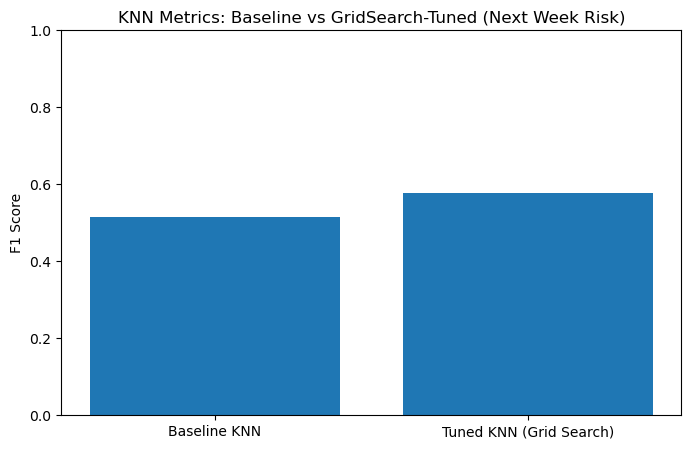

In [242]:
import matplotlib.pyplot as plt

methods = ['Baseline KNN', 'Tuned KNN (Grid Search)']
f1_scores = [baseline_knn_f1, tuned_knn_f1]

plt.figure(figsize=(8, 5))
plt.bar(methods, f1_scores)
plt.ylabel('F1 Score')
plt.title('KNN Metrics: Baseline vs GridSearch-Tuned (Next Week Risk)')
plt.ylim(0, 1)
plt.show()


In [243]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "="*80)
print("CROSS-VALIDATION WITH MULTIPLE METRICS")
print("="*80)

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

results = cross_validate(
    lr,
    X_train_smote,
    y_train_smote,
    cv=skfold,
    scoring=scoring,
    return_train_score=True
)

print("\nCross-Validation Results (Mean ± Std):")
for metric in scoring:
    train_scores = results[f'train_{metric}']
    test_scores = results[f'test_{metric}']
    print(f"{metric:20s} - Train: {train_scores.mean():.4f} (±{train_scores.std():.4f})  "
          f"Test: {test_scores.mean():.4f} (±{test_scores.std():.4f})")



CROSS-VALIDATION WITH MULTIPLE METRICS

Cross-Validation Results (Mean ± Std):
accuracy             - Train: 0.7252 (±0.0103)  Test: 0.6763 (±0.0360)
precision_weighted   - Train: 0.7262 (±0.0102)  Test: 0.6791 (±0.0358)
recall_weighted      - Train: 0.7252 (±0.0103)  Test: 0.6763 (±0.0360)
f1_weighted          - Train: 0.7248 (±0.0104)  Test: 0.6751 (±0.0365)


There is a slight sign of overfitting since all evaluation metrics are higher for training data.

# 7. Model Evaluation and Comparison


BASELINE LOGISTIC REGRESSION – EVALUATION
Accuracy:  0.6135
Precision (macro): 0.5893
Recall (macro):    0.5835
F1-score (macro):  0.5842

Per-class metrics:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       125
           1       0.51      0.44      0.47        82

    accuracy                           0.61       207
   macro avg       0.59      0.58      0.58       207
weighted avg       0.60      0.61      0.61       207



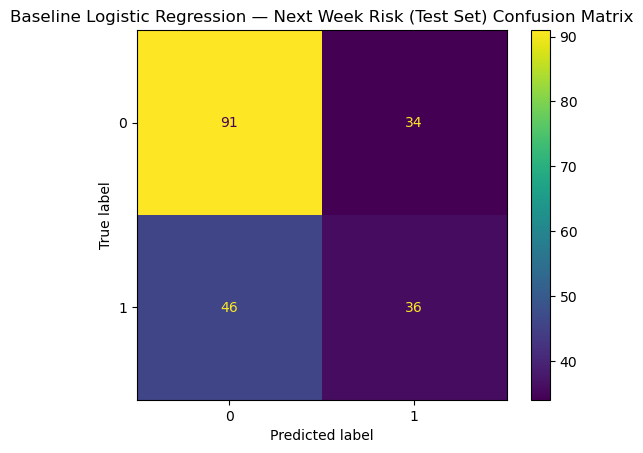


SMOTE LOGISTIC REGRESSION – EVALUATION
Accuracy:  0.5797
Precision (macro): 0.5735
Recall (macro):    0.5765
F1-score (macro):  0.5719

Per-class metrics:
              precision    recall  f1-score   support

           0       0.67      0.59      0.63       125
           1       0.47      0.56      0.51        82

    accuracy                           0.58       207
   macro avg       0.57      0.58      0.57       207
weighted avg       0.59      0.58      0.58       207



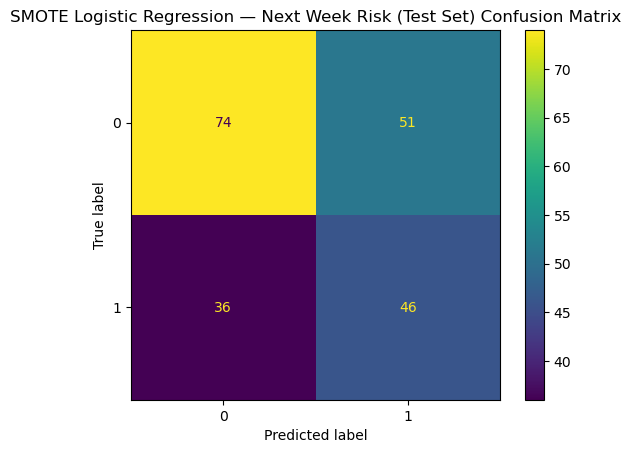


RFE LOGISTIC REGRESSION (5 FEATURES) – EVALUATION
Accuracy:  0.6667
Precision (macro): 0.6564
Recall (macro):    0.6611
F1-score (macro):  0.6574

Per-class metrics:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       125
           1       0.57      0.63      0.60        82

    accuracy                           0.67       207
   macro avg       0.66      0.66      0.66       207
weighted avg       0.67      0.67      0.67       207



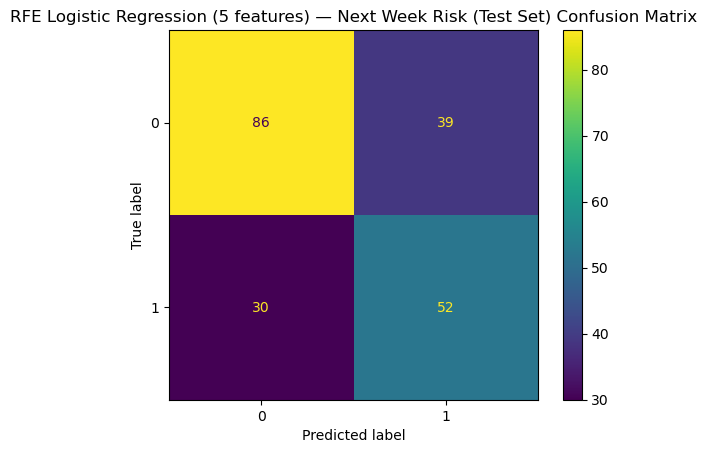


TUNED KNN – EVALUATION
Accuracy:  0.6329
Precision (macro): 0.6277
Recall (macro):    0.6331
F1-score (macro):  0.6265

Per-class metrics:
              precision    recall  f1-score   support

           0       0.72      0.63      0.68       125
           1       0.53      0.63      0.58        82

    accuracy                           0.63       207
   macro avg       0.63      0.63      0.63       207
weighted avg       0.65      0.63      0.64       207



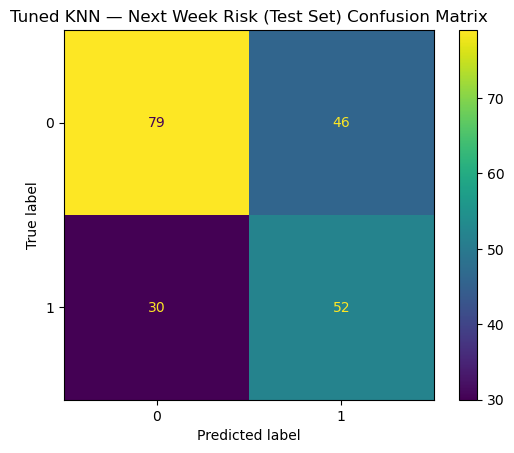


SMOTE + RFE LOGISTIC REGRESSION – EVALUATION
Accuracy:  0.6763
Precision (macro): 0.6614
Recall (macro):    0.6607
F1-score (macro):  0.6610

Per-class metrics:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       125
           1       0.59      0.59      0.59        82

    accuracy                           0.68       207
   macro avg       0.66      0.66      0.66       207
weighted avg       0.68      0.68      0.68       207



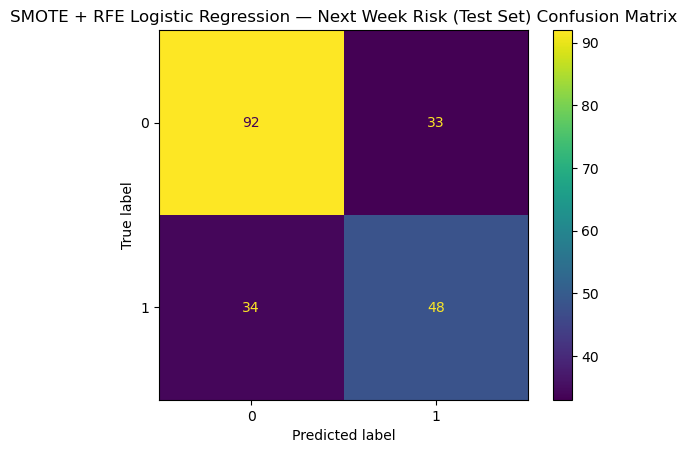

In [244]:
def evaluate_model(name, y_true, y_pred, labels=None):
    print("\n" + "="*80)
    print(f"{name.upper()} – EVALUATION")
    print("="*80)

    acc = accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision (macro): {prec_macro:.4f}")
    print(f"Recall (macro):    {rec_macro:.4f}")
    print(f"F1-score (macro):  {f1_macro:.4f}")

    print("\nPer-class metrics:")
    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()
    plt.title(f"{name} — Next Week Risk (Test Set) Confusion Matrix")
    plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec_macro,
        "Recall": rec_macro,
        "F1-Score": f1_macro
    }

results = []

results.append(
    evaluate_model(
        "Baseline Logistic Regression",
        y_test,
        y_pred_baseline,
        labels=[0, 1]
    )
)

results.append(
    evaluate_model(
        "SMOTE Logistic Regression",
        y_test,
        y_pred_smote,
        labels=[0, 1]
    )
)

results.append(
    evaluate_model(
        "RFE Logistic Regression (5 features)",
        y_test,
        y_test_pred_rfe,
        labels=[0, 1]
    )
)

results.append(
    evaluate_model(
        "Tuned KNN",
        y_test,
        y_pred_knn_tuned,
        labels=[0, 1]
    )
)

results.append(
    evaluate_model(
        "SMOTE + RFE Logistic Regression",
        y_test,
        y_pred_smote_rfe,
        labels=[0, 1]
    )
)


In [245]:
comparison_df = pd.DataFrame(results)
print(comparison_df)


                                  Model  Accuracy  Precision    Recall  \
0          Baseline Logistic Regression  0.613527   0.589260  0.583512   
1             SMOTE Logistic Regression  0.579710   0.573477  0.576488   
2  RFE Logistic Regression (5 features)  0.666667   0.656404  0.661073   
3                             Tuned KNN  0.632850   0.627691  0.633073   
4       SMOTE + RFE Logistic Regression  0.676329   0.661376  0.660683   

   F1-Score  
0  0.584170  
1  0.571877  
2  0.657425  
3  0.626496  
4  0.661012  


# 8. Results and Discussion

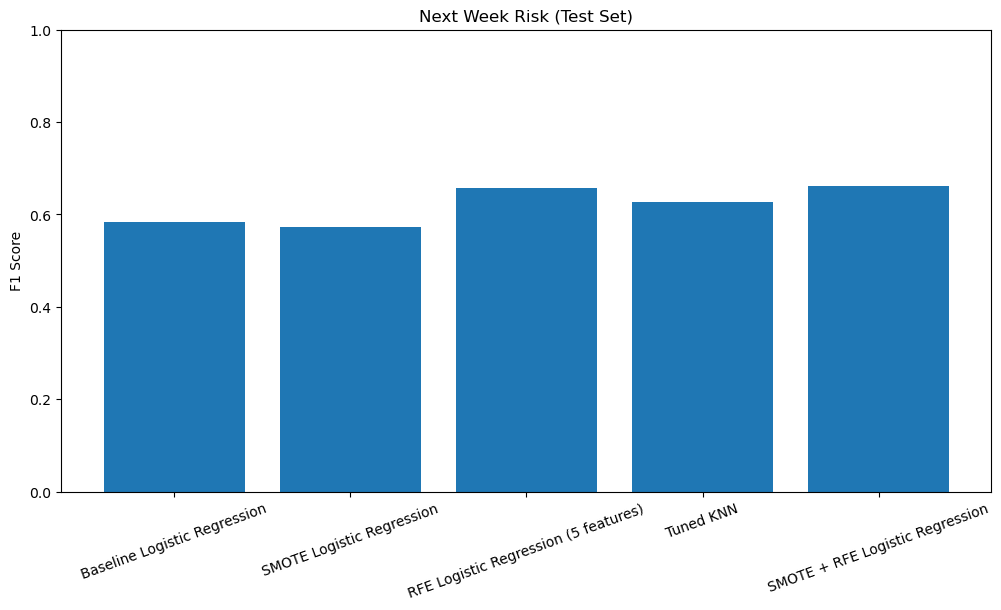

In [248]:
plt.figure(figsize=(12, 6))
plt.bar(comparison_df["Model"], comparison_df["F1-Score"])
plt.ylabel("F1 Score")
plt.title("Next Week Risk (Test Set)")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.show()


The test-set F1 scores indicate that model performance improves as feature selection and targeted optimization are introduced. The baseline Logistic Regression and SMOTE-only Logistic Regression achieve similar performance, suggesting that class rebalancing alone does not substantially improve predictive power. In contrast, incorporating Recursive Feature Elimination (RFE) leads to a noticeable increase in F1 score, highlighting the importance of selecting the most informative features for next-week risk prediction. The tuned KNN model performs competitively but does not outperform the optimized Logistic Regression models, indicating that distance-based methods offer limited additional benefit for this dataset. Overall, the highest performance is achieved by the SMOTE + RFE Logistic Regression model, demonstrating that combining class balancing with feature selection provides the most robust and generalizable results.

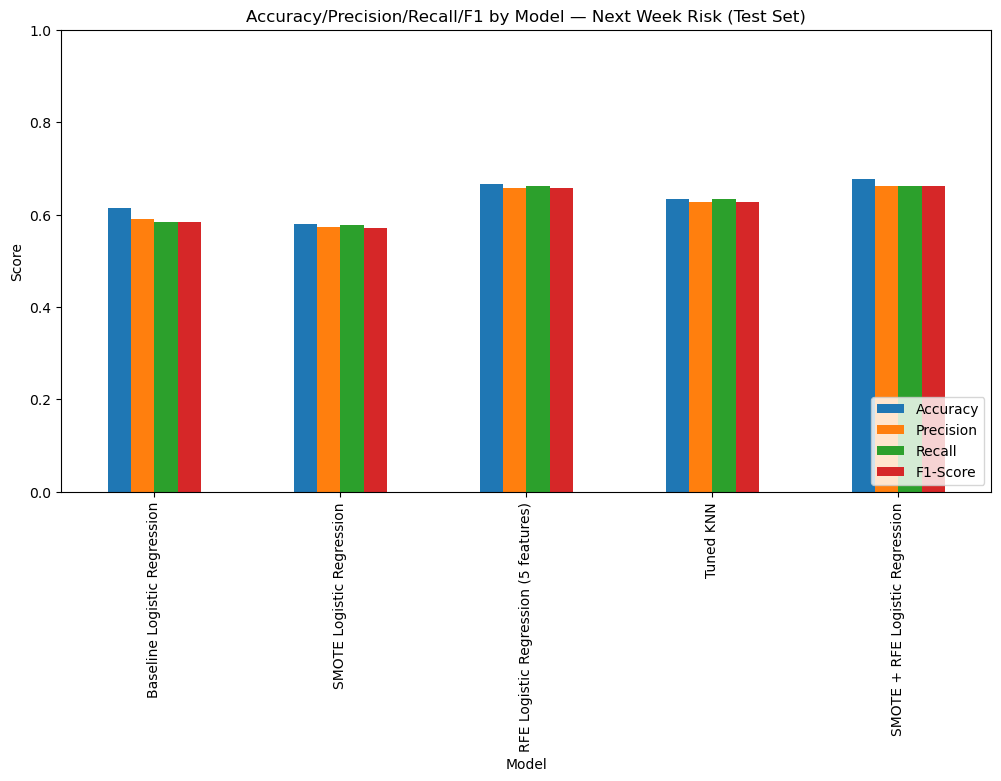

In [247]:
comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(
    kind="bar",
    figsize=(12, 6)
)
plt.ylabel("Score")
plt.title("Accuracy/Precision/Recall/F1 by Model — Next Week Risk (Test Set)")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()


The comparison of accuracy, precision, recall, and F1 score across models on the test set shows consistent performance trends. Baseline Logistic Regression and SMOTE-only Logistic Regression achieve similar scores across all metrics, indicating that class rebalancing alone does not substantially improve classification performance. Introducing Recursive Feature Elimination (RFE) leads to a marked improvement in all metrics, suggesting that removing irrelevant or noisy features enhances model generalization. The tuned KNN model performs competitively but remains slightly below the optimized Logistic Regression models, particularly in F1 score, which reflects the balance between precision and recall. The highest overall performance is achieved by the SMOTE + RFE Logistic Regression model, which demonstrates the strongest and most balanced results across all evaluation metrics, making it the most reliable model for next-week risk prediction.

# 9. Conclusions

## Interpretation of Results

The models show stable but only moderate performance on the test set. This suggests that predicting next-week stock risk is a difficult problem. Baseline Logistic Regression and SMOTE Logistic Regression perform similarly, which indicates that class balancing alone does not greatly improve results. When Recursive Feature Elimination (RFE) is added, performance improves across all metrics. This shows that a smaller set of important features captures most of the useful signal.

Even the best-performing model does not achieve very high accuracy or F1 score. This is expected for stock-related predictions. Stock prices and risk are affected by many factors that are not included in the dataset. These include political events, economic policy changes, climate-related disruptions, and unexpected global events. Because these factors are external and unpredictable, model performance is naturally limited.

## Feature Importance and Misclassification Patterns

RFE shows that only a few features are strongly related to next-week risk. Removing less useful features helps the model generalize better. However, misclassifications still occur, especially near class boundaries. Higher-risk cases are more difficult to predict correctly. This is likely because sudden risk changes often happen due to external events rather than past market behavior.

Model performance also varies by class. Lower-risk cases are easier to predict, while higher-risk cases are harder. This is common in financial data, where extreme events are rare.

## Limitations and Challenges

The main limitation of this analysis is that it only uses historical market data. Important factors such as politics, climate change, and global economic conditions are not included. As a result, the model cannot predict sudden market shocks well.

Another challenge is class imbalance. While SMOTE helps, synthetic data cannot fully represent real market behavior. The model also shows higher variation in test performance, which suggests the dataset is noisy and limited in size. Implementing resampling, cross-validation, and evaluation metrics correctly was also challenging and required careful setup.

## Real-World Applicability

In practice, this model could be used as a risk-screening tool rather than a final decision-maker. It can help identify stocks that may require closer attention. Logistic Regression is suitable for this purpose because it is simple and easy to interpret.

For deployment, the model would need regular retraining and monitoring. Predictions should be combined with news analysis and expert judgment. Relying only on the model could lead to poor decisions, especially during unusual market conditions.

## Future Work

Future improvements could include adding external data such as news sentiment, political indicators, macroeconomic data, or climate-related signals. More historical data would also help improve stability.

# 10. References

Brown, M. (2013). Dow Jones Index [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5788V.